In [ ]:
import firebase_admin

databaseURL = 'https://activity-5-4dbe0-default-rtdb.firebaseio.com'
cred_obj = firebase_admin.credentials.Certificate(
    'activity-5-4dbe0-firebase-adminsdk-4a07w-9c406c048d.json'
)
default_app = firebase_admin.initialize_app(cred_obj, {
	'databaseURL':databaseURL
	})

In [24]:
import time
from firebase_admin import db
import serial

ref = db.reference("/gyroscope_readings")

# Serial setup
ser = serial.Serial('COM12', 9600)  # Update with your serial port and baud rate

# Run the data collection in a controlled manner
try:
    # Control variable to run the loop
    running = True
    start_time = time.time()  # Record the start time

    while running:
        if ser.in_waiting:
            data = ser.readline().decode('utf-8').strip()
            print(f"Raw data: {data}")  # Debug print

            # Validate the data format before processing
            if ',' in data:
                try:
                    x, y, z = map(float, data.split(','))
                    timestamp = time.time()
                    data_entry = {
                        'timestamp': timestamp,
                        'x': x,
                        'y': y,
                        'z': z
                    }
                    ref.push(data_entry)
                    print(f"Data pushed: {data_entry}")
                except ValueError as ve:
                    print(f"Error parsing data: {ve}")
            else:
                print(f"Ignoring unexpected data: {data}")
                
        # Check for a condition to stop the loop, for example, running for a specific duration
        if time.time() - start_time > 1800:  # Stop after 30 minutes
            running = False

except Exception as e:
    print(f"An error occurred: {e}")
finally:
    ser.close()
    print("Serial connection closed.")

Raw data: Started
Ignoring unexpected data: Started
Raw data: Accelerometer sample rate = 104.00 Hz
Ignoring unexpected data: Accelerometer sample rate = 104.00 Hz
Raw data: 0.00, -0.01, 1.02
Data pushed: {'timestamp': 1722986213.9968305, 'x': 0.0, 'y': -0.01, 'z': 1.02}
Raw data: 0.00, -0.01, 1.02
Data pushed: {'timestamp': 1722986215.1286082, 'x': 0.0, 'y': -0.01, 'z': 1.02}
Raw data: 0.00, -0.00, 1.02
Data pushed: {'timestamp': 1722986215.9899437, 'x': 0.0, 'y': -0.0, 'z': 1.02}
Raw data: -0.00, -0.00, 1.02
Data pushed: {'timestamp': 1722986216.9889185, 'x': -0.0, 'y': -0.0, 'z': 1.02}
Raw data: 0.00, -0.01, 1.02
Data pushed: {'timestamp': 1722986218.0031695, 'x': 0.0, 'y': -0.01, 'z': 1.02}
Raw data: 0.00, -0.00, 1.02
Data pushed: {'timestamp': 1722986219.004278, 'x': 0.0, 'y': -0.0, 'z': 1.02}
Raw data: 0.00, -0.00, 1.02
Data pushed: {'timestamp': 1722986220.0060632, 'x': 0.0, 'y': -0.0, 'z': 1.02}
Raw data: 0.00, -0.01, 1.02
Data pushed: {'timestamp': 1722986221.0029106, 'x': 0.0

KeyboardInterrupt: 

In [25]:
ref = db.reference('/gyroscope_readings')

# Fetch data from Firebase
data = ref.get()
import pandas as pd
import json

# Check and convert data format
if isinstance(data, str):
    data = json.loads(data)

# Convert Firebase data to DataFrame
data_list = []
if isinstance(data, dict):
    for key, value in data.items():
        value['id'] = key  # Add the key (ID) to each entry
        data_list.append(value)
elif isinstance(data, list):
    data_list = data  # Directly use the list if data is already a list of dictionaries

df = pd.DataFrame(data_list)

# Save DataFrame to CSV
csv_filename = 'gyroscope_readings.csv'
df.to_csv(csv_filename, index=False)



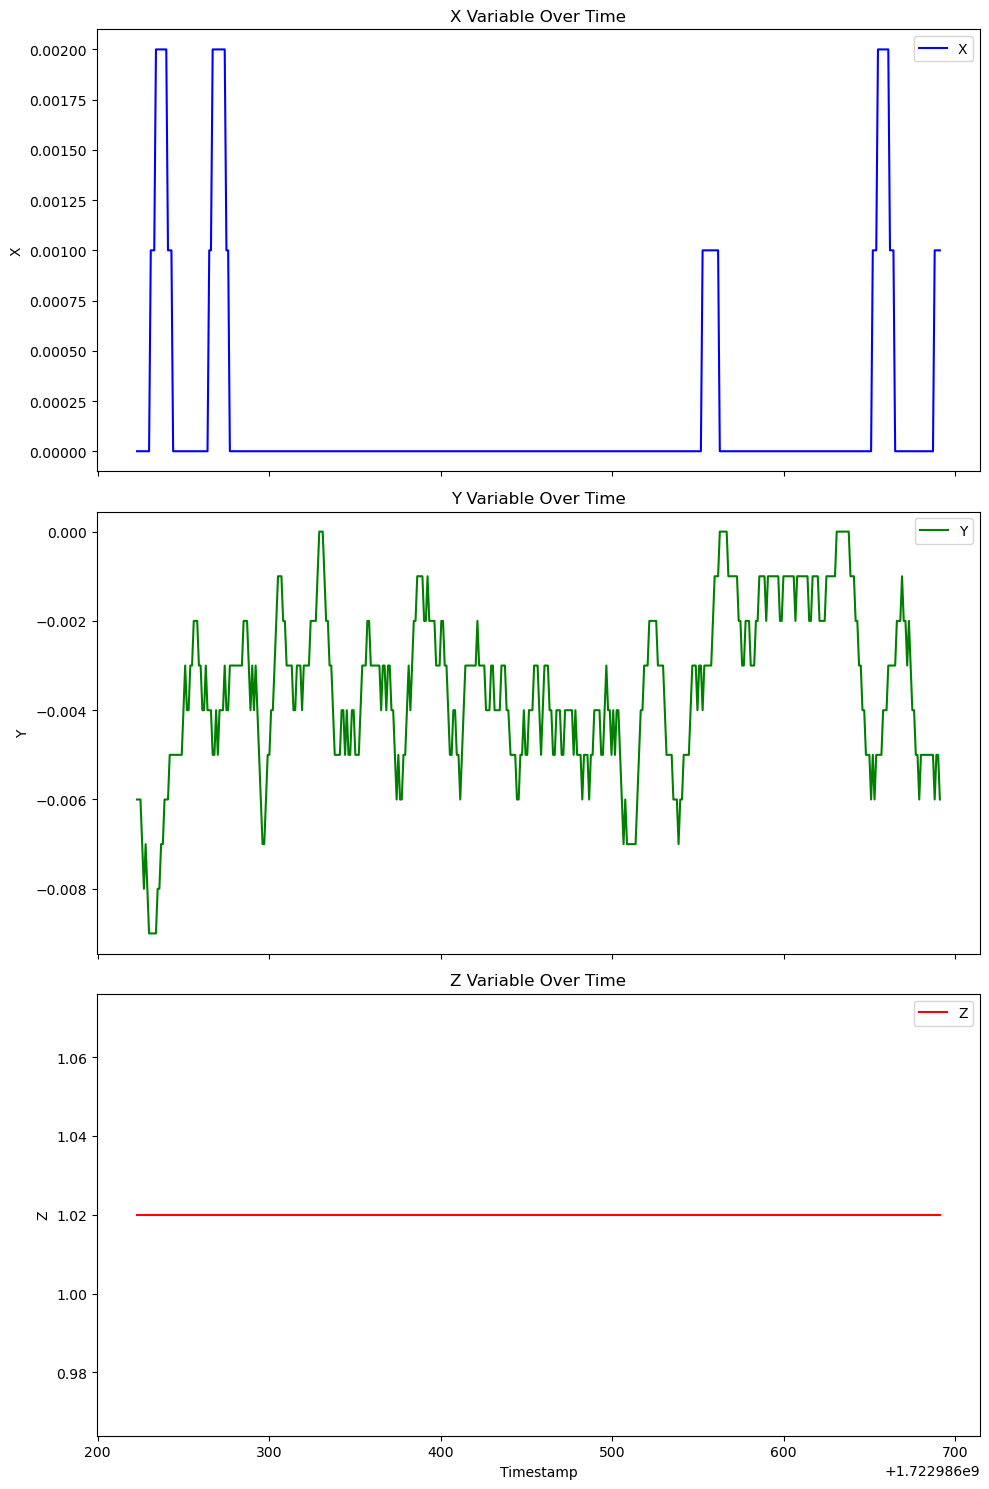

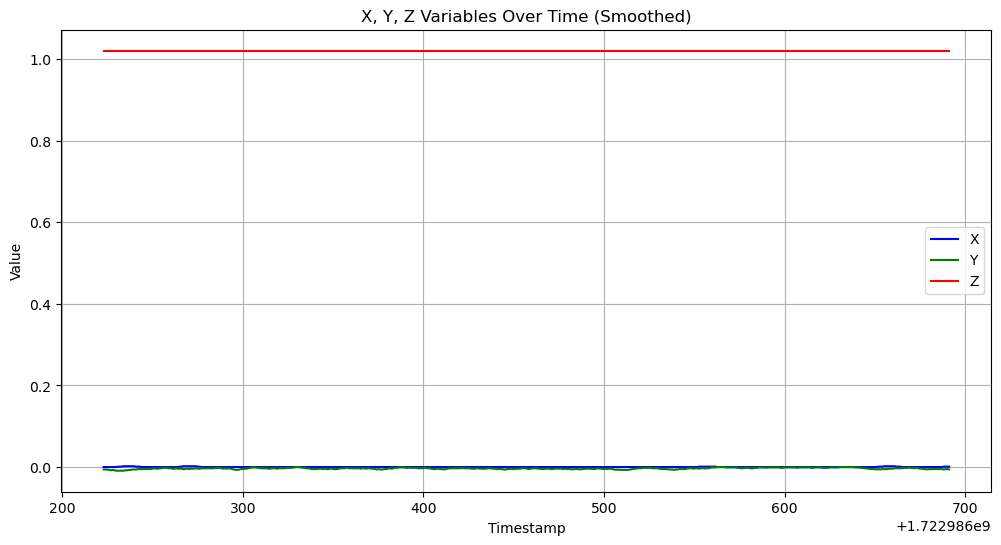

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the cleaned CSV file
df = pd.read_csv('gyroscope_readings.csv')

# Define a function to apply a moving average filter
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Apply the moving average filter to x, y, z with a window size of 10 (you can adjust this value)
window_size = 10
df['x_smoothed'] = moving_average(df['x'], window_size)
df['y_smoothed'] = moving_average(df['y'], window_size)
df['z_smoothed'] = moving_average(df['z'], window_size)

# Plot x, y, z variables separately
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot x
axs[0].plot(df['timestamp'], df['x_smoothed'], label='X', color='blue')
axs[0].set_ylabel('X')
axs[0].legend(loc='upper right')
axs[0].set_title('X Variable Over Time')

# Plot y
axs[1].plot(df['timestamp'], df['y_smoothed'], label='Y', color='green')
axs[1].set_ylabel('Y')
axs[1].legend(loc='upper right')
axs[1].set_title('Y Variable Over Time')

# Plot z
axs[2].plot(df['timestamp'], df['z_smoothed'], label='Z', color='red')
axs[2].set_ylabel('Z')
axs[2].legend(loc='upper right')
axs[2].set_title('Z Variable Over Time')
axs[2].set_xlabel('Timestamp')

plt.tight_layout()
plt.show()

# Plot all three variables in a single graph
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['x_smoothed'], label='X', color='blue')
plt.plot(df['timestamp'], df['y_smoothed'], label='Y', color='green')
plt.plot(df['timestamp'], df['z_smoothed'], label='Z', color='red')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('X, Y, Z Variables Over Time (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()
